In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [24]:
# from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchinfo import summary
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import torchvision
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
df = pd.read_csv('/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv')#.head(4)
print(f'Количество уникальных пациентов: {df.Patient.nunique()}')
print('-----------------------------------------------------------')
df.head(4)

Количество уникальных пациентов: 110
-----------------------------------------------------------


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0


# **1. Создаем списки путей картинок и масок**

In [143]:
brain_scans = []
mask_files = glob.glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:2])
print(mask_files[:2])
print(len(brain_scans))
print(len(mask_files))

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']
3929
3929


-------------------------------------------------
-------------------------------------------------
-------------------------------------------------

# **2. Передварительный анализ**

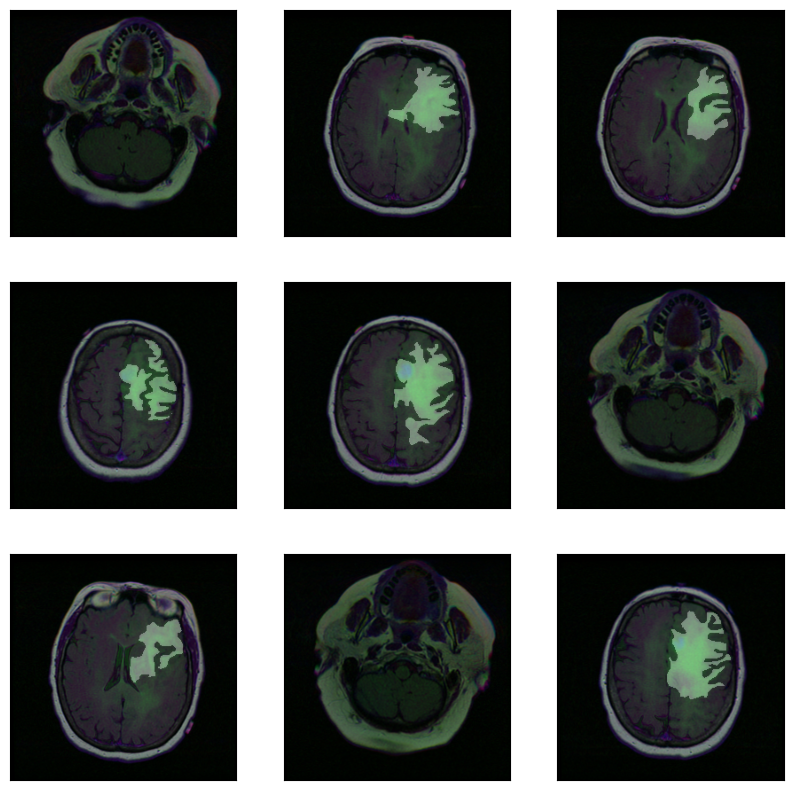

In [39]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.3)
    plt.xticks([]), plt.yticks([])
plt.show()

# **3. Смотрим содержимое каналов масок**

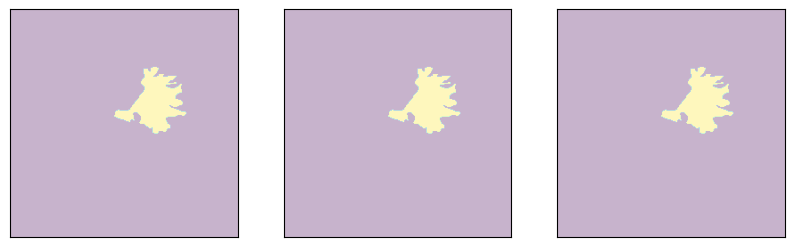

In [68]:
rows,cols=1,3
fig=plt.figure(figsize=(10,10))
for i in np.arange(1,4):
    fig.add_subplot(rows,cols,i)
    msk_path=mask_files[2]
    msk=cv2.imread(msk_path)
    plt.imshow(msk.transpose(-1,0,1)[i-1],alpha=0.3)
    plt.xticks([]), plt.yticks([])
plt.show()

In [100]:
# читаем картинку маски, 4меняем каналы местасми на (3,250,250),
an = cv2.imread(mask_files[2], 1).transpose(2,0,1)#/255
r,g,b = an

# координаты пикселей маски
nzs = np.nonzero(r)#(r==255)
instances = np.unique(g[nzs])
nzs

(array([ 65,  65,  65, ..., 139, 139, 139]),
 array([160, 161, 162, ..., 163, 164, 165]))

**Уникальные значения в каждом канале:**

In [130]:
lst = []
for _ in [0,1,2]:
    k = r,g,b
    h = 'rgb'
    for i in k[_]:
        for j in i:
            if j not in lst: lst.append(j)
    print(f'Значения в канале {h[_]}: {lst}')

Значения в канале r: [0, 255]
Значения в канале g: [0, 255]
Значения в канале b: [0, 255]


# **4. Создаем список annots с массивами array аннотаций:**

In [153]:
# если на картинке нет людей, т.е. цифр 255 в слое 'r', то картинка пропускается, иначе добавляется
from tqdm import tqdm
annots = []
for ann in tqdm(mask_files):
    _ann = cv2.imread(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 255 not in np.unique(r): continue
    annots.append(ann)
print(f'Количество элементов: {len(annots)}')
print(f'Количество уникальных элементов: {len(set(annots))}')
print(f'Пример содержимого: {annots[:1]}')

100%|██████████| 3929/3929 [00:09<00:00, 418.75it/s]

Количество элементов: 1373
Количество уникальных элементов: 1373
Пример содержимого: ['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif']


# **5. train_test_split**

In [161]:
from sklearn.model_selection import train_test_split
_annots = [i.split('/')[-1].replace('.tif','') for i in annots]
# _annots = stems(annots)
trn_items, val_items = train_test_split(_annots, test_size=0.2, random_state=2)
print(f'Длина trn_items: {len(trn_items)}')
print(f'Длина val_items: {len(val_items)}')
print(f'Пример содержимого trn_items: {trn_items[:1]}')
print(f'Пример содержимого val_items: {val_items[:1]}')

Длина trn_items: 1098
Длина val_items: 275
Пример содержимого trn_items: ['TCGA_DU_7010_19860307_43_mask']
Пример содержимого val_items: ['TCGA_DU_7018_19911220_27_mask']


# **6. Аугментация**

In [ ]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

# **дальше еще не рабочее**

In [142]:
st = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_35_mask.tif'
st.split('/')[-1].replace('_mask','')[:-4]

'TCGA_DU_7306_19930512_35'

In [ ]:
'/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_35_mask.tif'

In [136]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items # список картинок: ['ADE_train_00016892', 'ADE_train_00004335', ....
        self.transforms = transforms
        self.N = N # ограничивает количество картинок для рассмотрения
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1) # делаем из картинки array и меняем каналы метстами, стало: (3,450,640)
        r,g,b = an # вытаскиваем отдельные каналы
        nzs = np.nonzero(r==4) # вытаскивает координатытточек людей, т.е. значений 4: (array([319, 319, 319, ..., 500, 500, 500]), array([139, 140, 141, ..., 429, 430, 613]))
        instances = np.unique(g[nzs]) # в слое r находим коорд людей, в слое g для каждого человека свои цифры, короче здесь список цифр, которые обозначают людей
        masks = np.zeros((len(instances), *r.shape), float) # (39, 512, 683),т.е. на картинке 39 людей, здесь созданы 39 нулевых масок
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id # маска состоит из 0 и 1, 0 - это черный фон, 1 - это человечек
        return masks # список масок на которых по одному человечку, обозначенному единичкой
    def __getitem__(self, ix):
        _id = self.items[ix] # название картинки
        img_path = f'images/training/{_id}.jpg' # путь к картинке
        mask_path = f'annotations_instance/training/{_id}.png' # путь к аннотации картинки
        masks = self.get_mask(mask_path) # это список масок людей на этой картинке, каждаякартинка
        obj_ids = np.arange(1, len(masks)+1) # array список по кол-ву картинок array([ 1,  2,  3,  4,  5,..., 36, 37, 38, 39])
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids) # количество масок (39)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i]) # (array([472, 472, 472, 472,..., 478, 478, 478]), array([343, 344, 345, 346,..., 345, 346, 347, 348]))
                                            # т.к. человечки это единички, то это True, здесь np.where возвращает координаты всех пикселей True (человечков)
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10): # я так понимаю,что этот цикл для избежания ошибки =0
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32) # список коробок переводим в тензор
        labels = torch.ones((num_objs,), dtype=torch.int64) # создаем список из единичек длиной по числу людей на картинке tensor([1, 1, 1, 1, ..... 1, 1, 1, 1])
        masks = torch.as_tensor(masks, dtype=torch.uint8) # список масок переводим в тензор
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #площадь: tensor([100., 100., 154., 143., 407., 456., 396., 256.,  90., 119., 180., 162.,
        # 200., 115., 243., 225., 196., 455., 147., 208., 216., 410.,  95., 115.,90., 147., 100., 132., 160.,  52., 216., 225., 312.,  80., 100., 100., 100., 100., 100.])
        # это площади всех коробок людей, здесь 39 людей и выходит столько же коробок
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # создаем список из ноликов длиной по числу людей на картинке tensor([0, 0, 0, 0, ..... 0, 0, 0, 0])
        image_id = torch.tensor([ix]) # tensor([0]) - индекс-тензор картинки
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]